In [124]:
import numpy as np
from numpy import exp, tanh
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.signal import find_peaks_cwt
import numpy.fft as fft

## Ejercicio 1

Considerar un sistema con dos poblaciones de neuronas descritas por un modelo tasa de disparo con una relación I-f semilineal:

$$\tau\frac{d f_e}{dt} = - f_{e} + g_{ee} S_e - g_{ei}S_{i} + I_{e}$$
$$\tau\frac{d f_i}{dt} = - f_{i} + g_{ie} S_e - g_{ii}S_{i} + I_{i}$$
donde $S_{e} = f_e H(f_e)$ y $S_{i} = f_i H(f_i)$

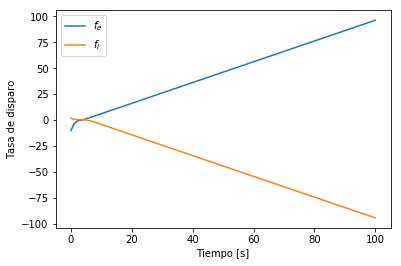

In [126]:
def heavy_side(f):
    if f > 0: return 1
    return 0
def S(f):
    return f*heavy_side(f)

# define the diferential equations 
def ode_function(y, t, I_e, I_i, g):
    fe = y[0]
    fi = y[1] 
    dfedt = - fe + g[0,0]*S(fe)- g[0,1]*S(fi) + I_e
    dfidt = - fi + g[1,0]*S(fe)- g[1,1]*S(fi) + I_i
    return np.array([dfedt,dfidt])
    
g = np.array([ [1,1],[-1,1]])
N = 100
t = np.linspace(0,100,N)
fe0 = -10
fi0 = 2
I_e = 1
I_i = 1
sol = odeint(ode_function, [fe0, fi0], t, args=(I_e, I_i, g) )
plt.plot(t,sol[:,0], '-',label=r'$f_{e}$')
plt.plot(t,sol[:,1], '-',label=r'$f_{i}$')
plt.xlabel(r"Tiempo [s]")
plt.ylabel(r"Tasa de disparo")
plt.legend()
plt.show()

## Ejercicio 2

Simular la dinámica de dos neuronas HH conectadas simétricamente con interacciones sináticas excitatorias. 

In [127]:
#### define the differential equations
def a_m(V):
    return 0.1 * (V + 40)/(1- exp(-(V+40)/10.0))
def b_m(V):
    return 4.0 * exp(- (V+65)/18)
def a_h(V):
    return 0.07 * exp(-(V + 65)/20)
def b_h(V):
    return 1/(1.0 + exp(-(V + 35)/10))
def a_n(V):
    return 0.01* (V + 55)/(1 - exp(-(V + 55)/10))
def b_n(V):
    return 0.125 *exp(-(V + 65)/80)
def m_inf(V):
    return a_m(V)/(a_m(V) + b_m(V))
def h_inf(V):
    return a_h(V)/(a_h(V) + b_h(V))
def n_inf(V):
    return a_n(V)/(a_n(V) + b_n(V))
def tau_m(V):
    return 1/(a_m(V) + b_m(V))
def tau_n(V):
    return 1/(a_n(V) + b_n(V))
def tau_h(V):
    return 1/(a_h(V) + b_h(V))

def s_inf(V):
    return  0.5*(1 + tanh(V/5.0))

In [220]:
C = 1;
V_na = 50;
V_k = -77;
V_l = -54.4;
g_na = 120;
g_k = 36;
g_l = 0.3;

In [319]:
# define the differential equations
# Y =[V1, m1,h1,n1,S1,V2,m2,h2,n2,S2]

def pend(y, t,I_ext, V_syn, tau,g_syn):
    
    V1, m1,h1,n1,S1,V2,m2,h2,n2,S2 = y
    dV1dt = 1/C* (I_ext - g_na *m1**3 * h1*(V1- V_na) - g_k * n1**4 * (V1 - V_k) - g_l * (V1 - V_l) - g_syn*S2*(V1 - V_syn))
    dV2dt = 1/C* (I_ext - g_na *m2**3 * h2*(V2- V_na) - g_k * n2**4 * (V2 - V_k) - g_l * (V2 - V_l)  - g_syn*S1*(V2 - V_syn))
    
    dm1dt =  (m_inf(V1) - m1)/tau_m(V1)
    dm2dt =  (m_inf(V2) - m2)/tau_m(V2)
    
    dn1dt =  (n_inf(V1) - n1)/tau_n(V1)
    dn2dt =  (n_inf(V2) - n2)/tau_n(V2)
    
    dh1dt =  (h_inf(V1) - h1)/tau_h(V1)
    dh2dt =  (h_inf(V2) - h2)/tau_h(V2)
    
    dS1dt = (s_inf(V1) - S1)/tau
    dS2dt = (s_inf(V2) - S2)/tau
    return [dV1dt, dm1dt, dh1dt, dn1dt, dS1dt,dV2dt, dm2dt, dh2dt, dn2dt, dS2dt]



In [483]:
def find_zero_pos(signal, start):
    
    if start >= signal.size: return start
    pos = start
    while  pos < signal.size and signal[pos]*signal[pos-1] > 0:
        pos = pos + 1
    return pos

def filter(value):
    if(abs(value) < 10): return 0
    return value
def calcular_taza_disparo(times,spikes,spikes2):
    assert times.size == spikes.size

    print spikes.size
   
    for i in range(0,times.size):
            if spikes[i] < 5: spikes[i] = 0.01
            if spikes2[i] < 5: spikes2[i] = 0.01       
    wdth = np.arange(1,30)
    peaks = find_peaks_cwt(spikes,wdth, noise_perc=30)
    if( len(peaks) < 5):
        print "no peaks found"
        return 0
    peaks = peaks[1:-1]
#     plt.plot(times,spikes,'-')
#     plt.plot(times,spikes2,'-.')
#     plt.plot(times[peaks],spikes[peaks],'o')
#     plt.xlim([100,200])
#     plt.show()
    period = np.mean(np.diff(times[peaks]))
    print "freq", 1/period
    return 1.0/period


def calcular_desfasaje(time, signal1, signal2):
    
    """ Calcula el desfasaje entre dos señales periódicas"""
    assert time.size == signal1.size
    assert time.size == signal2.size
    
    for i in range(0,time.size):
            if signal1[i] < 5: signal1[i]= 0.01
            if signal2[i] < 5: signal2[i] = 0.01

    wdth = np.arange(1,25)
    peaks = find_peaks_cwt(signal1,wdth, noise_perc=30)
    
    if( len(peaks) < 3 ): return 0
    ancho = (peaks[2] - peaks[1])/2
    print "ancho", ancho

    interval1 = [ max(peaks[1] - ancho,0), peaks[1] + ancho]
    print interval1
    pos2 = np.argmax(signal2[interval1[0]:interval1[1]])
    pos1 = np.argmax(signal1[interval1[0]:interval1[1]])
    delta_t = time[pos2] - time[pos1]
    period = time[peaks[2]] - time[peaks[1]]
#     plt.plot(time,signal1,'-')
#     plt.plot(time,signal2,'-.')
#     plt.xlim([100,150])
#     plt.show()
    return delta_t/period


    

#### Parte A

 Fijo $V_{syn} = 0$

In [484]:

def run_simulation(V_syn):
    t = np.linspace(0,600,50000)
    I_ext = 10 # suficiente para que dispare
    tau = 3
    n = 20
    g_syn = np.linspace(0,16,n)
    plt.figure()
    indices = t > 100
    spikes = []
    tasas = []
    desfasajes = []
    # V1, m1,h1,n1,S1,V2,m2,h2,n2,S2 
    y0 = [0, 
          0,
          0,
          0,
          0,
          0,
          0,
          0,
          0,
          0]
    for i in range(0,n):
        print "==============="
        print  "g_syn",g_syn[i]
        sol = odeint(pend, y0, t, args=(I_ext, V_syn,tau, g_syn[i]))
    #     plt.subplot(n, 1, i + 1)
    #     plt.xlim([20,40])
    #     plt.plot(t[t_indices], sol[t_indices, 0] - mean_value, 'b', label='V1(t)')
    #     plt.show()
    #     plt.plot(t[t_indices], sol[t_indices, 5] - mean_value , 'r', label='V2(t)')
    #     plt.show()
    #     plt.text(10,0,r"$g_{syn}$ = %lf"%g_syn[i])
#         sol[indices,0] = sol[indices,0] - np.mean(sol[indices,0])
#         sol[indices,5] = sol[indices,5] - np.mean(sol[indices,5])

        tasa = calcular_taza_disparo(t[indices],sol[indices,0], sol[indices,5])
        desfasaje = calcular_desfasaje(t[indices], sol[indices,0],sol[indices,5])
        print "desfasaje:",desfasaje
        tasas.append([g_syn[i],tasa])
        desfasajes.append([g_syn[i], desfasaje])
    data = np.array(tasas)
    plt.plot(data[:,0], data[:,1]*1000,'>-')
    plt.xlabel(r"$g_{syn}$")
    plt.ylabel(r"Tasa de disparo [Hz]")
    plt.show()
    data= np.array(desfasajes)
    plt.plot(data[:,0],data[:,1],'x-')
    plt.xlabel(r"$g_{syn}$")
    plt.ylabel(r"$Desfasaje$")
    plt.show()



g_syn 0.0
41666
freq 0.068350483434
ancho 601
[677, 1879]
desfasaje: 0.0
g_syn 0.842105263158
41666
freq 0.0642601670798
ancho 643
[4136, 5422]
desfasaje: 0.0
g_syn 1.68421052632
41666
freq 0.0580075764454
ancho 717
[7645, 9079]
desfasaje: 0.0
g_syn 2.52631578947
41666
freq 0.024853794629
ancho 1679
[10265, 13623]
desfasaje: 0.0
g_syn 3.36842105263
41666
freq 0.0118554085455
ancho 3516
[12011, 19043]
desfasaje: 0.0
g_syn 4.21052631579
41666
no peaks found
ancho 5776
[13345, 24897]
desfasaje: 0.0
g_syn 5.05263157895
41666
no peaks found
ancho 7570
[14300, 29440]
desfasaje: 0.0
g_syn 5.89473684211
41666
no peaks found
ancho 8134
[17259, 33527]
desfasaje: 0.0
g_syn 6.73684210526
41666
no peaks found
ancho 6787
[21301, 34875]
desfasaje: 0.0
g_syn 7.57894736842
41666
no peaks found
ancho 5435
[25356, 36226]
desfasaje: 0.0
g_syn 8.42105263158
41666
no peaks found
ancho 4535
[28056, 37126]
desfasaje: 0.0
g_syn 9.26315789474
41666
no peaks found
ancho 3625
[30786, 38036]
desfasaje: 0.0
g_syn 1

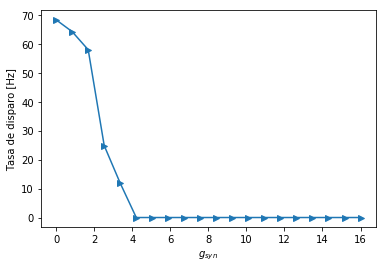

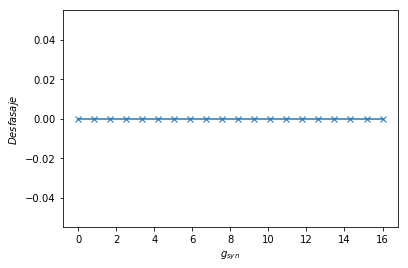

In [485]:
V_syn = 0
run_simulation(V_syn)

### Parte B

Fijo $V_{syn} =  -80$

In [ ]:
V_syn =  -80
run_simulation(V_syn)

g_syn 0.0
41666
freq 0.068350483434
ancho 601
[677, 1879]
desfasaje: 0.0
g_syn 0.842105263158
41666


Se oberva que para $V_{syn} = 0 mV$ la frecuencia disminuye al aumentar la conducctancia y la diferencia de fase se hace cero, es decir, tienden a alinearse. Mientras que para $V_{syn} = -80 mV$ la frecuencia no cambia mucho pero la fase si, pues las neuronas tienden a ponerse en contrafase.